In [1]:
from ast import Str
from collections import defaultdict
import itertools
import os
import random
import time
from typing import Callable, Optional
import torch
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from mtp.mheads._abc import AbstractDisributionHeadConfig
from mtp.mheads import MHEADS
from tqdm import tqdm

# set theme
sns.set_theme()


class SyntheticDataset(data.Dataset):
    """Synthetic dataset for multi-head training."""

    def __init__(self, num_samples, d_model, horizon, d_output, seed=42):
        """
        Args:
            num_samples: Number of samples in the dataset
            d_model: Input dimension
            horizon: Output sequence length
            d_output: Output vocabulary size
            seed: Random seed for reproducibility
        """
        self.num_samples = num_samples
        self.d_model = d_model
        self.horizon = horizon
        self.d_output = d_output

        # Set seed for reproducibility
        torch.manual_seed(seed)

        # Generate all data upfront
        self.x = torch.randn(num_samples, d_model)
        self.y = torch.randint(0, 2, (num_samples, horizon)) * (d_output - 1)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


def get_grad_norm(params):
    return torch.norm(
        torch.cat([p.grad.view(-1) for p in params if p.grad is not None]), p=2
    ).item()


def get_param_norm(params):
    return torch.norm(
        torch.cat([p.view(-1) for p in params if p is not None]), p=2
    ).item()


def evaluate(model, val_dataloader):
    pass


def run_train(
    model,
    train_dataloader,
    val_dataloader,
    add_loss_dict=False,
    lr=1e-3,
    seed=42,
    device="cuda" if torch.cuda.is_available() else "cpu",
    epochs=10,
    **kwargs,
):
    """Test if CP distribution can recover a target distribution on small scale."""

    # setup
    log_dict = defaultdict(list)
    torch.manual_seed(seed)
    random.seed(seed)

    # Train
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    model.to(device)
    start_time = time.time()
    iteration = 0
    for epoch in range(epochs):
        model.train()

        for batch_idx, (x, y) in enumerate(train_dataloader):
            optimizer.zero_grad()

            x = x.to(device)
            y = y[:, : model.config.horizon].to(device)

            out = model(x, y)
            out.loss.backward()
            optimizer.step()

            if out.loss_dict is not None and add_loss_dict:
                for k, v in out.loss_dict.items():
                    # Add or create new key if not exists
                    if k not in log_dict:
                        log_dict[k] = []
                    log_dict[k].append(v)

            # also add grad_norm and loss to log_dict
            log_dict["loss"].append(out.loss.item())
            log_dict["grad_norm"].append(get_grad_norm(model.parameters()))
            log_dict["param_norm"].append(get_param_norm(model.parameters()))
            log_dict["logits_norm"].append(out.logits.norm().item())
            log_dict["epoch"].append(epoch)
            log_dict["batch"].append(batch_idx)

            iteration += 1

            if out.loss.isnan():
                print(f"Loss is NaN at epoch {epoch}, batch {batch_idx}!")
                break

        # Print epoch summary
        if epoch % 1 == 0:
            evaluate(model, val_dataloader)

    # Add mt_name to log_dict for tracking
    log_dict["iteration"] = list(range(iteration))

    # Plot training metrics using seaborn
    return log_dict


def plot_training_metrics(
    log_dicts: list[dict],
    save_path: str = "results/plots/train_mhead_moe.png",
    is_log_metric_fn: Callable[[str], bool] = lambda x: False,
    reduce_fn: Optional[Callable[[str], str]] = None,  # e.g. "min", "max", "mean"
    **kwargs,
):
    """Plot training metrics using seaborn."""
    df = pd.concat([pd.DataFrame(log_dict) for log_dict in log_dicts])
    g = sns.relplot(
        data=df,
        **kwargs,
    )

    if reduce_fn is not None and reduce_fn(kwargs["y"]) is not None:
        x, y = kwargs["x"], kwargs["y"]
        gp = [c for c in df.columns if c != x]
        df = df.groupby(gp, as_index=False)[y].agg(reduce_fn(kwargs["y"]))

    if is_log_metric_fn(kwargs["y"]):
        g.set(yscale="log")

    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight")
        print(f"Saved plot to {save_path}")


def get_dataloaders(d_model, horizon, d_output, n_train, n_val, batch_size, seed=0):
    train_ds = SyntheticDataset(
        num_samples=n_train,
        d_model=d_model,
        horizon=horizon,
        d_output=d_output,
        seed=seed,
    )
    test_ds = SyntheticDataset(
        num_samples=n_val,
        d_model=d_model,
        horizon=horizon,
        d_output=d_output,
        seed=seed,
    )
    train_dl = data.DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        drop_last=True,
    )
    test_dl = data.DataLoader(
        test_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        drop_last=True,
    )
    return train_dl, test_dl


if __name__ == "__main__":

    # Common HPs
    BATCH_SIZE = 8
    LR = 1e-2
    EPOCHS = 1
    N_TRAIN = 100
    N_VAL = 10

    # Plot
    # ranks = [2]
    # horizons = [2, 32, 128]
    # seeds = [0]
    # d_models = [32]
    # d_outputs = [2, 8, 1024, 2048]

    # Large `horizon`, small `d_output`
    ranks = [2]
    horizons = [128, 512, 1024]
    seeds = [0]
    d_models = [2]
    d_outputs = [2]

    # # Large `d_output`, small `horizon`
    # ranks = [32]
    # horizons = [8]
    # seeds = [0]
    # d_models = [32]
    # d_outputs = [512, 1024, 2048]

    plot_kwargs = {
        # "row": "d_model",
        "col": "d_output",
        "hue": "name",
        "x": "iteration",
        "kind": "line",
        "is_log_metric_fn": lambda x: x != "loss",
        "reduce_fn": lambda x: "mean" if x == "epoch_time" else None,
    }

    configs = [
        {
            "name": n,
            "mt_name": n,
            "mt_kwargs": {
                "horizon": h,
                "rank": r,
                "d_model": dm,
                "d_output": do,
                'pos_func': p
            },
            "seed": s,
        }
        for r, h, s, dm, do, n, p in itertools.product(
            ranks,
            horizons,
            seeds,
            d_models,
            d_outputs,
            ["cp", "mps", "moe"],
            ['abs', 'square']
        )
    ]

    log_dicts = []
    pbar = tqdm(configs)
    for config in configs:
        dstring = f"Dm: {config['mt_kwargs']['d_model']} | Do: {config['mt_kwargs']['d_output']} | R: {config['mt_kwargs']['rank']} | H: {config['mt_kwargs']['horizon']}"
        pbar.set_description(f"{config['mt_name']} | {dstring}")

        try:

            model = MHEADS[config["mt_name"]](
                AbstractDisributionHeadConfig(**config["mt_kwargs"])
            )

            train_dl, val_dl = get_dataloaders(
                d_model=config["mt_kwargs"]["d_model"],
                horizon=config["mt_kwargs"]["horizon"],
                d_output=config["mt_kwargs"]["d_output"],
                n_train=N_TRAIN,
                n_val=N_VAL,
                batch_size=BATCH_SIZE,
                seed=config["seed"],
            )

            start_time = time.time()

            log_dict = run_train(
                model=model,
                train_dataloader=train_dl,
                val_dataloader=val_dl,
                lr=LR,
                epochs=EPOCHS,
                **config,
            )

            log_dict["name"] = config["name"]
            log_dict["pos_func"] = config["mt_kwargs"]["pos_func"]
            log_dict["horizon"] = config["mt_kwargs"]["horizon"]
            log_dict["rank"] = config["mt_kwargs"]["rank"]
            log_dict["d_model"] = config["mt_kwargs"]["d_model"]
            log_dict["d_output"] = config["mt_kwargs"]["d_output"]
            log_dict["epoch_time"] = (time.time() - start_time) / EPOCHS
            log_dicts.append(log_dict)
        except Exception as e:
            print(f"Error training {config['mt_name']} | {dstring}: {e}")
            continue

        pbar.update()

mps | Dm: 2 | Do: 2 | R: 2 | H: 1024:  78%|███████▊  | 14/18 [00:22<00:09,  2.46s/it]

Loss is NaN at epoch 0, batch 4!


moe | Dm: 2 | Do: 2 | R: 2 | H: 1024: 100%|██████████| 18/18 [00:35<00:00,  2.70s/it]

<Figure size 1000x500 with 0 Axes>

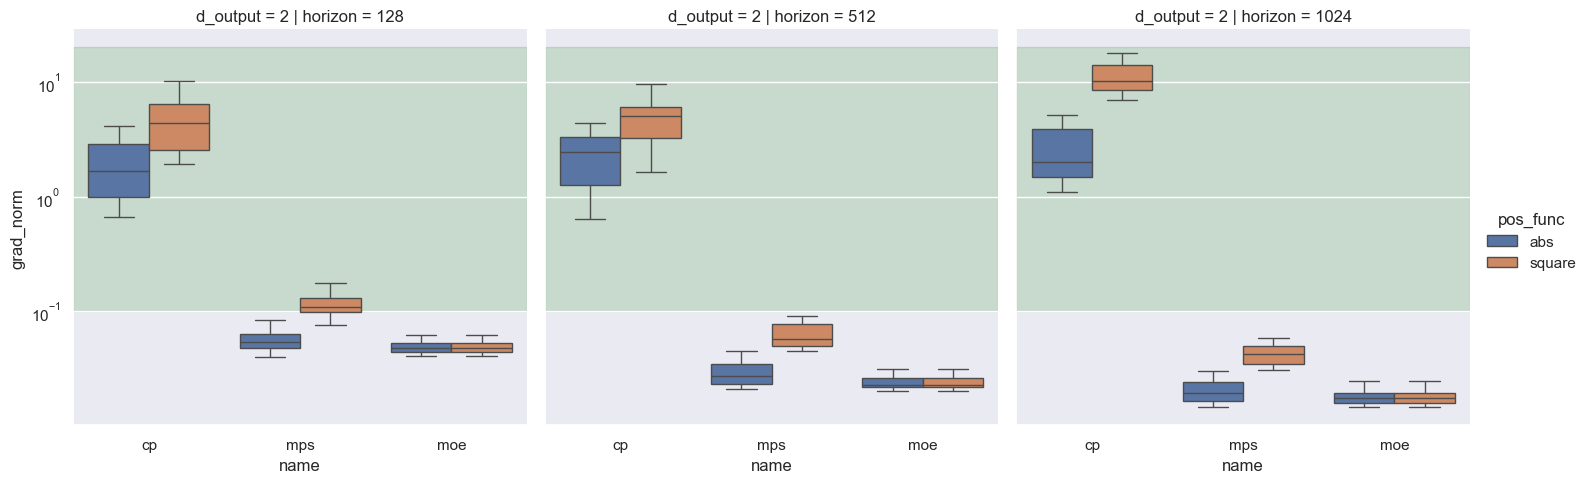

In [5]:
df = pd.concat([pd.DataFrame(log_dict) for log_dict in log_dicts], ignore_index=True)

sns.set_theme()
plt.figure(figsize=(10, 5))
g = sns.catplot(
    data=df, x="name", 
    y="grad_norm", 
    hue="pos_func", 
    col="horizon", 
    row="d_output",
    kind="box",
    showfliers=False,
)
g.set(yscale="log")

# Add green background between grad_norm=1 and grad_norm=20 to indicate "good" region
for ax in g.axes.flatten():
    ax.axhspan(0.1, 20, color="green", alpha=0.15, zorder=0)